In [82]:
#https://www.tensorflow.org/install/pip
#https://medium.com/geekculture/neural-machine-translation-using-seq2seq-model-with-attention-9faea357d70b
import numpy as np
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
#from keras.layers.normalization import BatchNormalization
from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding,Flatten,Dropout, Dense, Concatenate, TimeDistributed, Bidirectional,Attention
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from statistics import mode
from nltk import word_tokenize
from nltk.stem import LancasterStemmer

In [2]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]
        
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )
        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )
        print(c_outputs, e_outputs)

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]



In [75]:
df=pd.read_csv("Reviews.csv",nrows=50)
print(df.columns)
df.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates\n",
df.dropna(axis=0,inplace=True)
 
detail_sentences=[]
summary_sentences=[]

#print(max([len(x) for x in df['Text']]))
#print(max([len(x) for x in df['Summary']]))
for detail,summary in zip(df['Text'][:3],df['Summary'][:3]):
    print("Review:",detail,"\n\tSummary:",summary,"\n")
    

for sent in df['Text']:
    # Add sos and eos tokens using string.join
    #sent_new = " ".join(['sos', sent, 'eos'])
    detail_sentences.append(sent)

for sent in df['Summary']:
    # Add sos and eos tokens using string.join
    #sent_new = " ".join(['sos', sent, 'eos'])
    summary_sentences.append(sent)
    

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. 
	Summary: Good Quality Dog Food 

Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". 
	Summary: Not as Advertised 

Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I

In [4]:
#[print("{}{}\n".format(sentence,len(sentence))) for sentence in detail_sentences]
#max_input_len= max([len(sentence) for sentence in detail_sentences])
#max_target_len=max([len(sentence) for sentence in summary_sentences])
#print(max_input_len,max_target_len)

1231 68


In [83]:
stop_words = set(stopwords.words('english')) 
stemm=LancasterStemmer()

def clean(texts,src):
        #remove the html tags
        #tokenize the text into words 
        words=word_tokenize(texts.lower())
        #filter words which contains \ 
        #integers or their length is less than or equal to 3
        words = list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
        #contraction file to expand shortened words
        #words= [contractions[w] if w in contractions else w for w in words ]
        #stem the words to their root word and filter stop words
        if src=="inputs":
              words= [stemm.stem(w) for w in words if w not in stop_words]
        else:
              words= [w for w in words if w not in stop_words]
        return words
    

In [88]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]

for in_txt,tr_txt in zip(detail_sentences,summary_sentences):
    in_words= clean(in_txt,"inputs")
    input_texts+= [' '.join(in_words)]
    input_words+= in_words
    #add 'sos' at start and 'eos' at end of text
    tr_words= clean("sos "+tr_txt+" eos","target")
    target_texts+= [' '.join(tr_words)]
    target_words+= tr_words
    
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_input_len = max([len(i) for i in input_texts])
max_target_len = max([len(i) for i in target_texts])    

In [95]:
X_train,X_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0,shuffle=True)

In [96]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(list(X_train))

encoder_x_train    =   input_tokenizer.texts_to_sequences(X_train) 
encoder_x_train_data    =   pad_sequences(encoder_x_train,  maxlen=max_input_len, padding='post') 
input_voc_size   =  len(input_tokenizer.word_index) +1

In [97]:
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(list(y_train))

decoder_y_train    =   target_tokenizer.texts_to_sequences(y_train) 
decoder_y_train_data    =   pad_sequences(decoder_y_train, maxlen=max_target_len, padding='post')
#remove the eos
decoder_in_train=decoder_y_train_data[:,:-1]
target_voc_size  =   len(target_tokenizer.word_index) +1

In [98]:
# [[[[[Encoder]]]]]
latent_dim=500

encoder_inputs = Input(shape=(max_input_len,)) 
enc_emb = Embedding(input_voc_size, latent_dim)(encoder_inputs) 
#LSTM 1 
#encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,name='lstm1')) 
#encoder_output1,forw_state_h1,forw_state_c1, back_state_h1, back_state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,name='lstm1') 
encoder_output1,state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
#encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,name='lstm2')) 
#encoder_output2, forw_state_h2,forw_state_c2,back_state_h2, back_state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,name='lstm2') 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
#LSTM 3 
#encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,name='lstm3')) 
#encoder_outputs1,forw_state_h,forw_state_c, back_state_h, back_state_c= encoder_lstm3(encoder_output2) 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,name='lstm3') 
encoder_outputs3,state_h3, state_c3= encoder_lstm3(encoder_output2) 

# Set up the [[[[[[[[decoder]]]]]]]]. 

encoder_states = [state_h3, state_c3]

#final_enc_h = Concatenate()([forw_state_h,back_state_h])
#final_enc_c = Concatenate()([forw_state_c,back_state_c])

#get context vector
#encoder_states = [final_enc_h,final_enc_c]

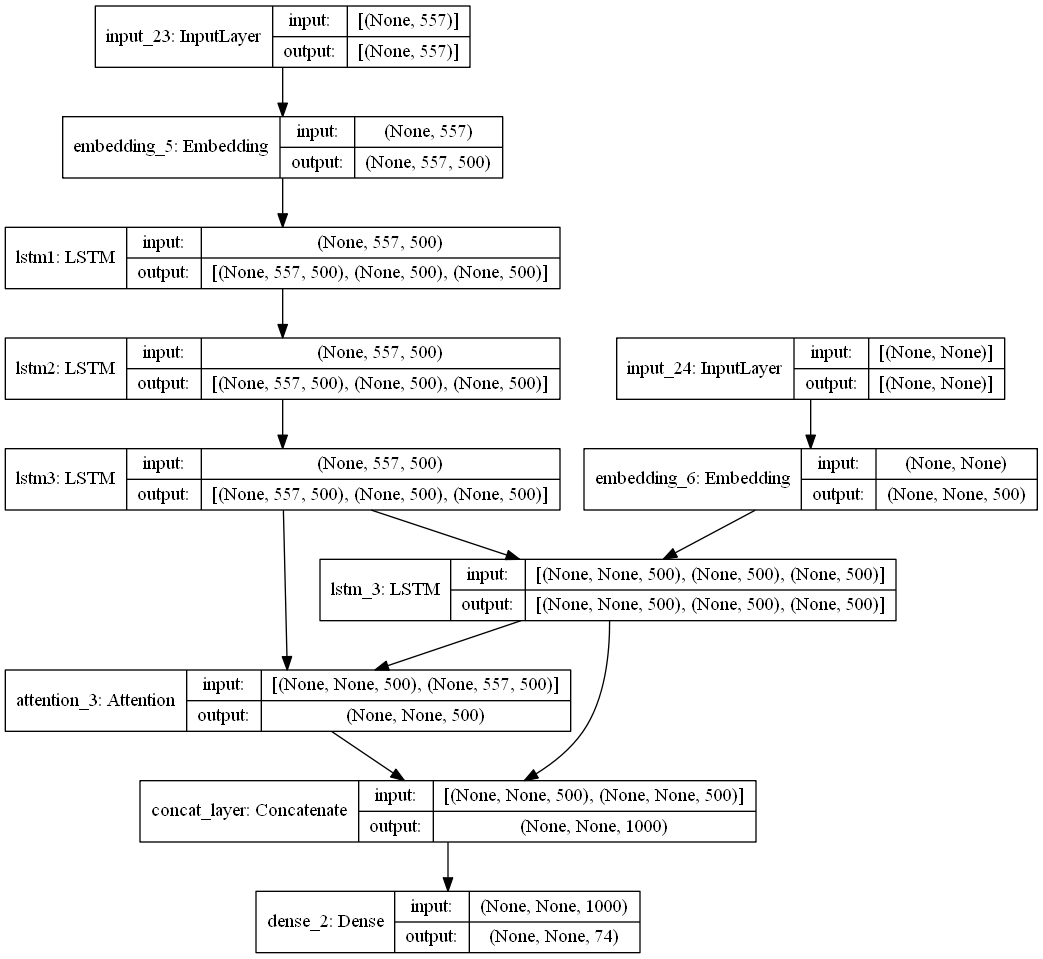

In [99]:
# decoder input and embedding

decoder_inputs = Input(shape=(None,)) 
#dec_emb_layer = Embedding(y_voc_size, 512) 
decoder_emb_layer = Embedding(target_voc_size, latent_dim) 
decoder_emb = decoder_emb_layer(decoder_inputs) 
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,_,_ = decoder_lstm(decoder_emb,initial_state=encoder_states) 

#[[attention layer]]
#attention_layer = AttentionLayer(name='attention_layer') 
#attention_out, attention_weights = attention_layer([encoder_outputs1, decoder_outputs]) 
attention=Attention()
attention_out=attention([decoder_outputs,encoder_outputs3])
# Concat attention output and decoder LSTM output 
merge = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_out])
#Dense layer
#decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_dense = Dense(target_voc_size, activation='softmax') 
decoder_outputs2 = decoder_dense(merge) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs2) 

model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = 'rmsprop', 
                 metrics = ['acc'])
    
#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [100]:
#https://github.com/thushv89/attention_keras/blob/master/src/examples/nmt_bidirectional/model.py

checkpoint = ModelCheckpoint("give Your path to save check points", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

encoder_input_data = encoder_in_train
decoder_input_data = decoder_in_train
#number of rows, sequence length, one step ahead not including sos
decoder_target_data=decoder_y_train_data.reshape(len(decoder_y_train),max_target_len, 1)[:,1:]
#history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,batch_size=128)

#encoder_input_test = encoder_in_test
#decoder_input_test = decoder_in_test
#decoder_target_test= decoder_y_test_data.reshape(len(decoder_y_test),max_target_len, 1)[:,1:]

#history=model.fit([encoder_input_data ,decoder_input_data], decoder_target_data ,epochs=3,batch_size=128,callbacks=callbacks_list)
history=model.fit([encoder_input_data ,decoder_input_data], decoder_target_data ,
                  epochs=3,
                  batch_size=512
                 )

model.save_weights("C:\\Users\\dnishimoto.BOISE\\lstm_model.h5") # can give whole path to save model

Epoch 1/3
1/1 [==============================] - 49s 49s/step - loss: 4.2978 - acc: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 45s 45s/step - loss: 1.0341 - acc: 0.9220
Epoch 3/3
1/1 [==============================] - 41s 41s/step - loss: 0.8734 - acc: 0.9220


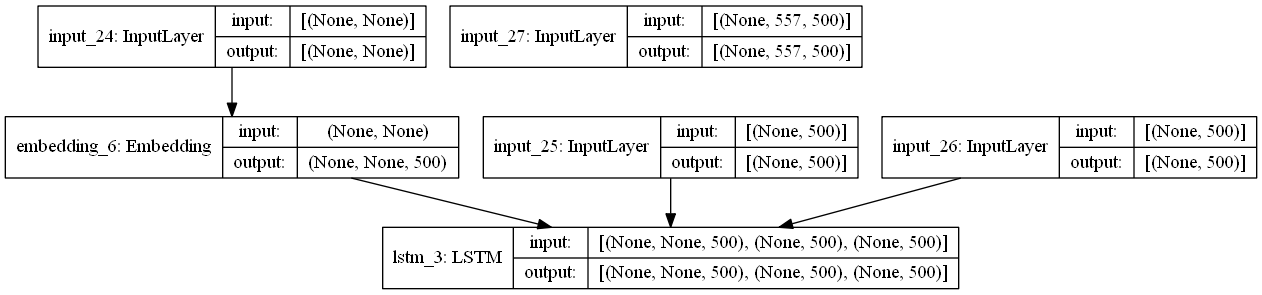

In [101]:
#https://medium.com/geekculture/neural-machine-translation-using-seq2seq-model-with-attention-9faea357d70b
#https://data-flair.training/blogs/machine-learning-text-summarization/
model.load_weights("C:\\Users\\dnishimoto.BOISE\\lstm_model.h5")

#[[[[[[[INFERENCE MODEL]]]]]]]
# encoder Inference model
#encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])
#encoder_model = Model(encoder_inputs,encoder_states)

en_outputs,state_h_enc,state_c_enc=model.layers[6].output

en_states=[state_h_enc,state_c_enc]

encoder_model = Model(model.input[0],[en_outputs]+en_states)

# Decoder Inference
decoder_state_input_h = Input(shape=(latent_dim,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_input_c = Input(shape=(latent_dim,))

# we need hidden state for attention layer
decoder_hidden_state_input = Input(shape=(max_input_len,latent_dim)) 
# get decoder states
#decoder_states_inputs = [decoder_state_h, decoder_state_c]

decoder_inputs=model.input[1]
decoder_emb_layer=model.layers[5]
decoder_lstm=model.layers[7]
decoder_embedding=decoder_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2=decoder_lstm(decoder_embedding,initial_state=[decoder_state_input_h,decoder_state_input_c])

# embedding layer 
#dec_emb2 = dec_emb_layer(decoder_inputs)
#decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

attention=model.layers[8]
attn_out2=attention([decoder_outputs2,decoder_hidden_state_input])
merge2=Concatenate(axis=-1)([decoder_outputs2,attn_out2])
# Attention inference
#attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

decoder_dense=model.layers[10]
decoder_output2=decoder_dense(merge2)
#decoder_states2= [state_h2, state_c2]
#decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                     [decoder_outputs2]+ [state_h2,state_c2])

#decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

#print(decoder_model.summary())
plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [102]:
target_index_word=target_tokenizer.index_word
source_word_index=input_tokenizer.index_word
source_index_word=input_tokenizer.word_index
target_word_index=target_tokenizer.word_index

In [105]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    
    count=0
    while not stop_condition:
        count+=1
        if count>1000:
            print('count exceeded')
            stop_condition=True
        output_words, dec_h, dec_c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        #print(output_tokens)
        word_index = np.argmax(output_words[0, -1, :])
        char=""
        if word_index in target_index_word:
            char = target_index_word[word_index]
            decoded_sentence += ' '+char
            print(decoded_sentence)
        else:
            stop_condition=True
        if char == 'eos' or len(decoded_sentence) >= max_input_len:
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = word_index
        print(target_seq[0,0])
        # Update states
        enc_h, enc_c = dec_h, dec_c
    
    return decoded_sentence

In [106]:
sentence="""sos I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. eos"""

input_sentence    =   input_tokenizer.texts_to_sequences([sentence]) 
input_sentence_seq    =   pad_sequences(input_sentence,  maxlen=max_input_len, padding='post') 
sentence=get_predicted_sentence(input_sentence_seq.reshape(1,max_input_len))

#enc_output, enc_h, enc_c = encoder_model.predict(input_sentence_seq)
#target_seq = np.zeros((1,1)) 
#target_seq[0, 0] = target_word_index['sos']
#output_words, dec_h, dec_c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
#word_index = np.argmax(output_words[0, -1, :])
#char = target_index_word[word_index]
#target_seq = np.zeros((1,1))
#target_seq[0, 0] = word_index
#enc_h, enc_c = dec_h, dec_c
#output_words, dec_h, dec_c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
#word_index = np.argmax(output_words[0, -1, :])
#if word_index in target_index_word:
#    char = target_index_word[word_index]
#    print(char)

print("done",sentence)



488.0
done 
